In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge, Lasso, ElasticNet 
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from sklearn.svm import SVR
from sklearn.exceptions import NotFittedError

import warnings
warnings.filterwarnings('ignore')

In [2]:
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rcParams['figure.figsize'] = (20, 10)
plt.style.use('ggplot')

# Custom scoring function

In [3]:
def scoring(y, y_pred, **kwargs):
    w = kwargs.get('weights')
    
    y_pred = pd.DataFrame(data = y_pred, columns=y.columns, index=y.index)
    intra_features = kwargs.get('intra')
    w_intra = w[w.columns[0]]
    daily_features = kwargs.get('daily')
    w_daily = w[w.columns[1]]
    
    y_pred_intra = y_pred[intra_features]
    y_pred_daily = y_pred[daily_features]
    
    y_intra = y[intra_features]
    y_daily = y[daily_features]
    
    res = np.array([])
    
    for i in y_intra.index:
        w_i = w_intra.loc[i]
        y_i = y_intra.loc[i]
        y_hat_i = y_pred_intra.loc[i]
        
        er = w_i * np.abs(y_i - y_hat_i)
        
        res = np.append(res, er)
        
    for i in y_daily.index:
        w_i = w_daily.loc[i]
        y_i = y_daily.loc[i]
        y_hat_i = y_pred_daily.loc[i]
        
        er = w_i * np.abs(y_i - y_hat_i)
        
        res = np.append(res, er)
    
    return np.sum(res)/len(res)

In [4]:
df = pd.read_csv('train.csv', index_col=0)

In [5]:
df.head()

,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,...,Ret_175,Ret_176,Ret_177,Ret_178,Ret_179,Ret_180,Ret_PlusOne,Ret_PlusTwo,Weight_Intraday,Weight_Daily
Id,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,8.0,NaN,75751,0.2254,11.0,NaN,...,-0.002688,0.002246,-0.000838,-6.953224e-04,0.000003,-0.001974,-0.019512,0.028846,1.251508e+06,1.564385e+06
2,NaN,NaN,NaN,NaN,3.0,0.388896,17369,0.0166,13.0,NaN,...,-0.000129,0.000123,0.000248,3.315418e-07,0.000003,0.000027,-0.002939,-0.010253,1.733950e+06,2.167438e+06
3,NaN,-0.696727,0.739591,-0.167928,9.0,0.471947,8277,0.3650,9.0,5.0,...,-0.000524,-0.000394,0.000116,5.322557e-04,0.000274,0.000784,-0.024791,0.015711,1.529197e+06,1.911497e+06
4,NaN,-0.694350,1.568248,0.479073,5.0,0.120653,22508,0.2654,13.0,5.0,...,0.000346,-0.000090,0.000288,-1.281102e-04,0.000074,0.000341,-0.005680,-0.002190,1.711569e+06,2.139462e+06
5,6.0,-1.736489,2.765531,1.245280,7.0,4.866985,22423,0.2138,13.0,4.0,...,-0.001235,0.000027,0.002449,8.619882e-06,0.001209,-0.000004,0.036104,-0.026552,1.267270e+06,1.584088e+06


In [6]:
# Defining columns for X/y features
X_features = list(df.columns[:146])
Y_features = list(df.columns[146:208])
Weight_features = list(df.columns[-2:])

intra = Y_features[:-2]
daily = Y_features[-2:]

In [7]:
# Understand Nan values distribution among columns
temp_df = (df.isnull().sum() / len(df))

temp_df = temp_df.drop(temp_df[temp_df == 0].index).sort_values(ascending = False)

In [8]:
print(f'Number of columns in original data: {df.shape[1]}')
print(f'Number of columns with NaN: {temp_df.size}')
print(f'Number of columns without NaN: {df.shape[1] - temp_df.size}')

temp_df = temp_df[:10]

Number of columns in original data: 210
Number of columns with NaN: 141
Number of columns without NaN: 69


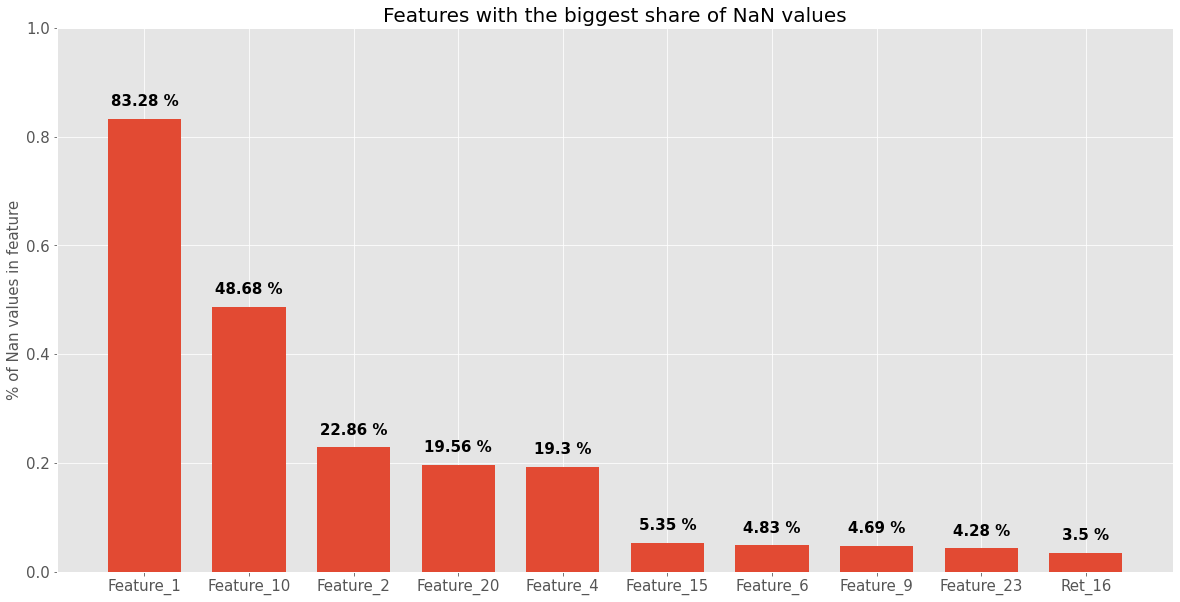

In [9]:
plt.bar(range(temp_df.size), temp_df, width = 0.7)
plt.xticks(range(temp_df.size), temp_df.index)
plt.ylim([0, 1])

plt.title('Features with the biggest share of NaN values', size = 20)
plt.ylabel('% of Nan values in feature', size = 15)

for x, y in zip(range(temp_df.size), temp_df):
    #u = str(temp_df.loc[x])
    label = f'{np.round(y*100,2)} %'.format(y)
    
    plt.annotate(label, (x,y), textcoords='offset points', xytext=(0, 13), ha='center', fontsize=15, fontweight='bold')

plt.show()

# Setting parameters for tunning

In [10]:
imputers = {'KNNImputer': KNNImputer(missing_values=np.nan),
            'SimpleImputer': SimpleImputer(missing_values=np.nan, strategy='mean')}

pca_use = [True, False]

regressors = {}

# Ridge
regressors['Ridge'] = {'reg': Ridge(),
                       'space': {'solver': ['auto','svd', 'cholesky', 'sparse_cg', 'sag'],
         'alpha': np.array([1.0, 0.1, 0.01, 0]),
         'fit_intercept': [True, False],
         'normalize': [True, False]}
         }

# Lasso
regressors['Lasso'] = {'reg': Lasso(fit_intercept=True, normalize=True),
                       'space': {'alpha': np.array([1.0, 0.1, 0.01, 0])}
                      }

# Elastic Net
regressors['Elastic Net'] = {'reg': ElasticNet(fit_intercept=True, normalize=True),
                             'space': {'alpha': np.array([1.0, 0.01, 0.001, 0.0001]),
                              'l1_ratio': np.arange(0.95, 1, 0.005)}
                            }

# Decision Tree
regressors['Decision Tree Regressor'] = {'reg': DecisionTreeRegressor(),
                                         'space': {
                                             'criterion': ['mse', 'friedman_mse', 'mae', 'poisson'],
                                             'min_samples_split': [10, 20, 40],
                                             'max_depth': [2, 6, 8],
                                             'min_samples_leaf': [20, 40, 100],
                                             'max_leaf_nodes': [5, 20, 100]
                                          }
                                        }

# Gradient Boosting Regressor
regressors['Gradient Boosting Regressor'] = {'reg': GradientBoostingRegressor(),
                             'space': {'n_estimators':[100, 150],
                            'learning_rate': [0.1, 0.05, 0.02, 0.01],
                            'max_depth':[6,4,8],
                            'min_samples_leaf':[3,5,9,17],
                            'max_features':[1.0,0.3,0.1] }
                            }

# RandomForestRegressor
regressors['Random Forest'] = {'reg': RandomForestRegressor(), 
                               'space': {
                                   'max_features': ['sqrt', 'log2'],
                                   'bootstrap': [True, False],
                                   'min_samples_leaf': [1, 2, 4],
                                   'min_samples_split': [2, 5, 10],
                                   'n_estimators': [100, 150, 200],
                                   'max_depth': [10, 20, 30]}
                              }

# SVM
regressors['SVM'] = {'reg': SVR(),
                     'space': {
                        'kernel': ['rbf', 'poly', 'linear'],
                        'gamma': [1e-4, 1e-3, 0.01, 0.1, 0.2, 0.5, 0.6, 0.9],
                        'C': [1, 10, 100, 1000, 10000]
                     }
                    }

# Important cell!!

In [11]:
W = df[Weight_features]

# Creating custom scoring functions
# Since we have to minimize error, we are providing parameter greater_is_better=False
cust_scorer = make_scorer(scoring, greater_is_better=False, weights = W, intra = intra, daily = daily)

# Running models

In [ ]:
# Main cell

for imp in imputers:
    print(imp)
    imputer = imputers.get(imp)
    
    imp_df = pd.DataFrame(data = imputer.fit_transform(df), columns=df.columns, index=df.index)
    X, y = imp_df[X_features], imp_df[Y_features]
    
    train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.25)
    
    # Loop for using/not PCA
    for u in pca_use:
        if u:
            for r in regressors:                    
                adj_space = {'pca__n_components': [2, 4, 5, 15],
                 'pca__svd_solver' : ['auto', 'full', 'randomized']}
                
                space = regressors.get(r).get('space')
                for k in space.keys():
                    adj_space['reg__'+k] = space.get(k)
                
                reg = regressors.get(r).get('reg')
                steps = [('pca', PCA()), ('reg', reg)]
                
                pipeline = Pipeline(steps)
            
                
                cv = RandomizedSearchCV(pipeline, param_distributions=adj_space, scoring=cust_scorer, cv = 4)
                                    
                try:
                    cv.fit(train_X, train_y)
                except:
                    print(f'Imputer:{imp}|\tPCA use:{u}|\tRegressor:{r}')
                    print('Is not Fitted')
                    continue

                y_pred = pd.DataFrame(data = cv.predict(val_X), columns=val_y.columns, index=val_y.index)
                
                print(f'Imputer:{imp}|\tPCA use:{u}|\tRegressor:{r}')
                print(f'Best values: {cv.best_params_}')
                print(f'WMAE: {np.round(scoring(val_y, y_pred, weights = W.loc[val_y.index], intra = intra, daily = daily),4)}')
                print(f'MAE: {np.round(mean_absolute_error(val_y, y_pred),4)}')
                print(f'RMSE: {np.round(np.sqrt(mean_squared_error(val_y, y_pred)),4)}')
                print(f'R^2: {np.round(r2_score(val_y, y_pred),4)}')
                
        else:
            for r in regressors:
                space = regressors.get(r).get('space')
                
                reg = regressors.get(r).get('reg')
            
                cv = RandomizedSearchCV(reg, param_distributions=space, scoring=cust_scorer, cv = 4)
                
                try:
                    cv.fit(train_X, train_y)
                except:
                    print(f'Imputer:{imp}|\tPCA use:{u}|\tRegressor:{r}')
                    print('Is not Fitted')
                    continue
                
                y_pred = pd.DataFrame(data = cv.predict(val_X), columns=val_y.columns, index=val_y.index)
                
                print(f'Imputer:{imp}|\tPCA use:{u}|\tRegressor:{reg}')
                print(f'Best values: {cv.best_params_}')
                print(f'WMAE: {np.round(scoring(val_y, y_pred, weights = W.loc[val_y.index], intra = intra, daily = daily),4)}')
                print(f'MAE: {np.round(mean_absolute_error(val_y, y_pred),4)}')
                print(f'RMSE: {np.round(np.sqrt(mean_squared_error(val_y, y_pred)),4)}')
                print(f'R^2: {np.round(r2_score(val_y, y_pred),4)}')

KNNImputer
Imputer:KNNImputer|	PCA use:True|	Regressor:Ridge
Already done
Imputer:KNNImputer|	PCA use:True|	Regressor:Lasso
Already done
Imputer:KNNImputer|	PCA use:True|	Regressor:Elastic Net
Already done
Imputer:KNNImputer|	PCA use:True|	Regressor:Decision Tree Regressor
Already done
Imputer:KNNImputer|	PCA use:True|	Regressor:Gradient Boosting Regressor
Is not Fitted
Imputer:KNNImputer|	PCA use:True|	Regressor:Random Forest
Best values: {'reg__n_estimators': 150, 'reg__min_samples_split': 5, 'reg__min_samples_leaf': 2, 'reg__max_features': 'log2', 'reg__max_depth': 30, 'reg__bootstrap': True, 'pca__svd_solver': 'full', 'pca__n_components': 4}
WMAE: 1664.3588
MAE: 0.001
RMSE: 0.0041
R^2: 0.1486
Imputer:KNNImputer|	PCA use:True|	Regressor:SVM
Is not Fitted
Imputer:KNNImputer|	PCA use:False|	Regressor:Ridge()
Best values: {'solver': 'sag', 'normalize': False, 'fit_intercept': False, 'alpha': 1.0}
WMAE: 1769.5725
MAE: 0.0011
RMSE: 0.0046
R^2: -0.0001
Imputer:KNNImputer|	PCA use:False|	R